# Linear Binary Pattern

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [18]:
from skimage import io
from skimage.feature import local_binary_pattern

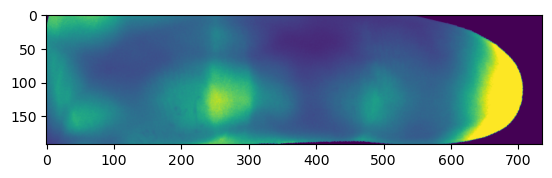

In [3]:
fingerprint = io.imread('../data/Data_FV_Spoofing_WS2025_26/PLUS/real/001/PLUS-FV3-Laser_PALMAR_001_01_02_01.png')
plt.imshow(fingerprint)
plt.show()

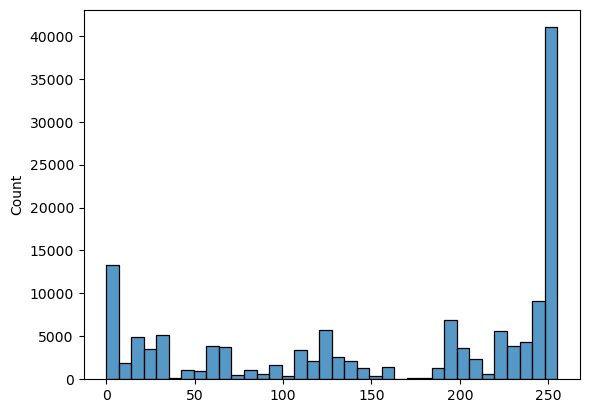

In [7]:
lbp = local_binary_pattern(fingerprint, P=8, R=1)
sns.histplot(lbp.ravel())
plt.show()

## Preparing fingerprint data

In [50]:
import re
from pathlib import Path

# Just for PLUS at the moment
def fingerprint_metadata(base_path):
    base_path = Path(base_path)
    pattern = re.compile(r"(.+)_(PALMAR|DORSAL)_([0-9]+)_([0-9]+)_([0-9]+)_([0-9]+).png")
    return [(*pattern.findall(f.name)[0], f) for f in base_path.rglob('*.png')]

In [70]:
data = fingerprint_metadata('../data/Data_FV_Spoofing_WS2025_26/PLUS/real/')
df = pd.DataFrame(metadata, columns=['scanner', 'side', 'subject', 'session', 'finger', 'image_id', 'path'])

int_cols = ['subject', 'session', 'finger', 'image_id']
df[int_cols] = df[int_cols].apply(pd.to_numeric, errors='raise').astype(int)

df.head()

,scanner,side,subject,session,finger,image_id,path
0,PLUS-FV3-Laser,PALMAR,64,1,9,3,../data/Data_FV_Spoofing_WS2025_26/PLUS/real/0...
1,PLUS-FV3-Laser,PALMAR,64,1,8,1,../data/Data_FV_Spoofing_WS2025_26/PLUS/real/0...
2,PLUS-FV3-Laser,PALMAR,64,1,2,4,../data/Data_FV_Spoofing_WS2025_26/PLUS/real/0...
3,PLUS-FV3-Laser,PALMAR,64,1,2,5,../data/Data_FV_Spoofing_WS2025_26/PLUS/real/0...
4,PLUS-FV3-Laser,PALMAR,64,1,7,1,../data/Data_FV_Spoofing_WS2025_26/PLUS/real/0...
